## Expérimentation
### Faites de votre mieux! - Partie 6

## Dataset

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up one level to `project` directory

In [2]:
import data.shots_data_retriever as shots_data_retriever
import importlib
importlib.reload(shots_data_retriever)

shotsDataRetriever = shots_data_retriever.ShotsDataRetriever()
df = shotsDataRetriever.get_df_for_milestone2_part4()

df

,game_id,play_num,period,is_goal,x_coord,y_coord,shot_type,is_empty_net,distance,angle_to_goal,...,last_event_x_coord,last_event_y_coord,time_since_last_event,distance_from_last_event,rebound,angle_change,speed,time_since_powerplay,away_skaters,home_skaters
0,2016020001,7,1,0,77,5,wrist,0,13.928388,21.037511,...,61,11,1,17.088007,False,0.000000,17.088007,0,5,5
1,2016020001,14,1,0,86,13,wrist,0,13.601471,72.897271,...,54,-5,5,36.715120,False,0.000000,7.343024,0,5,5
2,2016020001,21,1,0,23,-38,wrist,0,77.025970,-29.560354,...,72,0,18,62.008064,False,0.000000,3.444892,0,5,5
3,2016020001,23,1,0,33,-15,slap,0,58.940648,-14.743563,...,77,-2,19,45.880279,False,0.000000,2.414752,0,5,5
4,2016020001,36,1,0,34,28,wrist,0,62.609903,26.565051,...,47,34,16,14.317821,False,0.000000,0.894864,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68060,2019021082,283,3,0,77,-23,backhand,0,26.419690,-60.524111,...,72,-21,21,5.385165,False,0.000000,0.256436,0,5,5
68061,2019021082,285,3,0,76,38,slap,0,40.496913,69.775141,...,95,-17,16,58.189346,False,0.000000,3.636834,0,5,5
68062,2019021082,286,3,0,79,10,backhand,0,14.866069,42.273689,...,76,38,2,28.160256,True,27.501452,14.080128,0,5,5
68063,2019021082,293,3,0,81,-7,snap,0,11.401754,-37.874984,...,60,40,32,51.478151,False,0.000000,1.608692,0,6,5


## Imports

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, RocCurveDisplay, log_loss, brier_score_loss, roc_auc_score, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR, LinearSVC
from sklearn.calibration import calibration_curve, CalibrationDisplay

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nathan-crms (ift_6289_a3). Use `wandb login --relogin` to force relogin


True

## Evaluation
#### Classe pour simplifier l'évaluation et la génération des figures

In [4]:
class EvalModel():
    def __init__(self, _percentile_bins, _proba_df, _label):
        self.percentile_bins = _percentile_bins
        self.proba_df = _proba_df
        self.label = _label

def get_goal_probas(model, X_test, y_test, name):
    y_proba = model.predict_proba(X_test)
    non_goal_proba = [proba[0] for proba in y_proba]
    goal_proba = [proba[1] for proba in y_proba]
    return {'proba': goal_proba, 'y_test': y_test, 'name': name}

def get_percentile_and_goal_proba(model, X_test, y_test):    
    y_proba = model.predict_proba(X_test)
    non_goal_proba = [proba[0] for proba in y_proba]
    goal_proba = [proba[1] for proba in y_proba]

    proba_df = X_test.copy()
    proba_df['non_goal_proba'] = non_goal_proba
    proba_df['goal_proba'] = goal_proba
    proba_df['is_goal'] = y_test
    
    percentile_bins = np.linspace(0, 1, 21)
    proba_df['percentile'] = pd.qcut(proba_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
    return percentile_bins, proba_df

def get_percentile_goal_rate(df, model, X_test, y_test, features, label):
    percentile_bins, proba_df = get_percentile_and_goal_proba(model, X_test, y_test)
    return EvalModel(percentile_bins[:-1], proba_df.groupby('percentile', observed=False)['is_goal'].mean(), label)

def get_percentile_goal_cumul(df, model, X_test, y_test, features, label):
    percentile_bins, proba_df = get_percentile_and_goal_proba(model, X_test, y_test)
    total_shots = proba_df['is_goal'].sum()
    return EvalModel(percentile_bins[:-1],  1 - proba_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots, label)

def goal_rate_figure(eval_models: list):
    plt.figure(figsize=(10, 6))
    for eval_model in eval_models:
        plt.plot(eval_model.percentile_bins, eval_model.proba_df, label=eval_model.label)
    plt.gca().invert_xaxis()
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
    plt.xlabel('Centile de la probabilité de but')
    plt.ylabel('Buts / (Tirs + Buts)')
    plt.title('Taux de buts')
    plt.legend()
    plt.grid()
    plt.show()

def goal_cumul_figure(eval_models: list):
    plt.figure(figsize=(10, 6))
    for eval_model in eval_models:
        plt.plot(eval_model.percentile_bins, eval_model.proba_df, label=eval_model.label)
    plt.gca().invert_xaxis()
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
    plt.xlabel('Centile de la probabilité de but')
    plt.ylabel('Proportion')
    plt.title('% de buts cumulé')
    plt.legend()
    plt.grid()
    plt.show()
    
def roc_figure(models):
    plt.figure(figsize=(10, 8))
    for model in models:
        y_test = model['y_test']
        proba = model['proba']
        name = model['name']
        display = RocCurveDisplay.from_predictions(
            y_test,
            proba,
            name=name,
            plot_chance_level=(name == "Model 1"),
            ax=plt.gca()
        )
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    
def calibration_figure(models):
    plt.figure(figsize=(10, 8))
    for model in models:
        y_test = model['y_test']
        proba = model['proba']
        name = model['name']
        display = CalibrationDisplay.from_predictions(
            y_test,
            proba,
            name=name,
            ax=plt.gca()
        )
    plt.xlabel("Moyenne de probabilité prédite")
    plt.ylabel("Fraction de positifs (Classe: 1)")
    plt.title("Courbe de fiabilité")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

## Encoded dataset

In [5]:
dataset = df.copy()
dataset = dataset.dropna()
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)
dataset['rebound'] = label_encoder.fit_transform(dataset['rebound'])

categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()
one_hot_encoded = onehot_encoder.fit_transform(dataset[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns))
dataset = dataset.drop(columns=categorical_columns)
encoded_dataset = pd.concat([dataset.reset_index(drop=True), one_hot_df.reset_index(drop=True)], axis=1)

encoded_dataset

,game_id,play_num,period,is_goal,x_coord,y_coord,is_empty_net,distance,angle_to_goal,game_seconds,...,time_since_powerplay,away_skaters,home_skaters,shot_type_backhand,shot_type_deflected,shot_type_slap,shot_type_snap,shot_type_tip-in,shot_type_wrap-around,shot_type_wrist
0,2016020001,7,1,0,77,5,0,13.928388,21.037511,71,...,0,5,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2016020001,14,1,0,86,13,0,13.601471,72.897271,173,...,0,5,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2016020001,21,1,0,23,-38,0,77.025970,-29.560354,241,...,0,5,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016020001,23,1,0,33,-15,0,58.940648,-14.743563,286,...,0,5,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2016020001,36,1,0,34,28,0,62.609903,26.565051,406,...,0,5,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294504,2019021082,283,3,0,77,-23,0,26.419690,-60.524111,3405,...,0,5,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0
294505,2019021082,285,3,0,76,38,0,40.496913,69.775141,3440,...,0,5,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0
294506,2019021082,286,3,0,79,10,0,14.866069,42.273689,3442,...,0,5,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0
294507,2019021082,293,3,0,81,-7,0,11.401754,-37.874984,3530,...,0,6,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## MLPClassifier (réseau de neurones)

### Finetuning des hyperparamètres

In [ ]:
X = encoded_dataset[['distance', 'angle_to_goal']]
y = encoded_dataset['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

mlp_run = wandb.init(
    project="IFT6758.2024-A02",
    name="mlp-hp_finetuned",
    entity="IFT6758-2024-A02",
    config={
        "model": "MLPClassifier",
    }
)

mlp = MLPClassifier(verbose=True)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [200, 500],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_mlp = grid_search.best_estimator_

y_proba = best_mlp.predict_proba(X_test)[:, 1]  # Probability for class 1 (is_goal)
y_pred = best_mlp.predict(X_test)

logloss = log_loss(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)

mlp_run.log({
    "log_loss": logloss,
    "brier_score": brier,
    "roc_auc": roc_auc,
    "accuracy": accuracy,
})

with open('./experiment/mlp-hp_finetuned.pkl','wb') as f:
    pickle.dump(best_mlp, f)

mlp_run.log_artifact('./experiment/mlp-hp_finetuned.pkl', type='model')

mlp_run.finish()

wandb: Currently logged in as: nathan-crms (IFT6758-2024-A02). Use `wandb login --relogin` to force relogin


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Iteration 1, loss = 0.29951721
Iteration 1, loss = 0.35309269
Iteration 1, loss = 0.30769318
Iteration 1, loss = 0.30259346
Iteration 1, loss = 0.68912676
Iteration 1, loss = 0.36006201
Iteration 1, loss = 0.35808644
Iteration 1, loss = 0.30120402
Iteration 2, loss = 0.29545646
Iteration 2, loss = 0.29644391
Iteration 2, loss = 0.29603424
Iteration 2, loss = 0.29486392
Iteration 2, loss = 0.29522281
Iteration 2, loss = 0.29577673
Iteration 2, loss = 0.29488499
Iteration 2, loss = 0.29587247
Iteration 3, loss = 0.29539630
Iteration 3, loss = 0.29453885
Iteration 3, loss = 0.29581740
Iteration 3, loss = 0.29576002
Iteration 3, loss = 0.29554124
Iteration 3, loss = 0.29457983
Iteration 3, loss = 0.29467589
Iteration 3, loss = 0.29578799
Iteration 4, loss = 0.29510215
Iteration 4, loss = 0.29453127
Iteration 4, loss = 0.29527949
Iteration 4, loss = 0.29449040
Iteration 4, loss = 0.29610677
Iteration 4, loss = 0.29508964
Iteratio

accuracy,▁
brier_score,▁
log_loss,▁
roc_auc,▁
accuracy,0.90205
brier_score,0.08357
log_loss,0.29471
roc_auc,0.71618


## XGBClassifier

### Finetune hyperparamétres

In [7]:
X = encoded_dataset[['distance', 'angle_to_goal']]
y = encoded_dataset['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf_xgb = xgb.XGBClassifier(eval_metric="logloss")
clf_xgb.fit(X_train, y_train)

xgb_hp_finetuned_run = wandb.init(
    project="IFT6758.2024-A02",
    name="xgb-hp_finetuned",
    entity="IFT6758-2024-A02",
    config={
        "model": "XGBClassifier",
    }
)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=clf_xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

y_proba = best_xgb.predict_proba(X_test)[:, 1]  # Probability for class 1 (is_goal)
y_pred = best_xgb.predict(X_test)

logloss = log_loss(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)

xgb_hp_finetuned_run.log({
    "log_loss": logloss,
    "brier_score": brier,
    "roc_auc": roc_auc,
    "accuracy": accuracy,
})

with open('./experiment/xgb-hp_finetuned.pkl','wb') as f:
    pickle.dump(best_xgb, f)
    
xgb_hp_finetuned_run.log_artifact('./experiment/xgb-hp_finetuned.pkl', type='model')

xgb_hp_finetuned_run.finish()

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.7s[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.2s
[CV] END colsam

accuracy,▁
brier_score,▁
log_loss,▁
roc_auc,▁
accuracy,0.902
brier_score,0.08361
log_loss,0.29446
roc_auc,0.71566


### Sélection des caractéristiques avec validation croisée (RFECV)

In [ ]:
X = encoded_dataset.drop(columns=['is_goal', 'game_id', 'play_num'])
y = encoded_dataset['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_hp_finetuned_feature_selection_run = wandb.init(
    project="IFT6758.2024-A02",
    name="xgb-hp_finetuned+feature_selection",
    entity="IFT6758-2024-A02",
    config={
        "model": "XGBClassifier",
    }
)

rfecv = RFECV(
    estimator=best_xgb,
    step=1,
    cv=5,
    scoring='accuracy',
    verbose=1,
)

rfecv.fit(X_train, y_train)
print(f"Optimal number of features: {rfecv.n_features_}")

selected_features = X_train.columns[rfecv.support_]
print("Selected features:", selected_features)

X_test_selected = X_test[selected_features]
y_pred = rfecv.estimator_.predict(X_test_selected)
print("Test accuracy with selected features:", accuracy_score(y_test, y_pred))

X = encoded_dataset[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
best_xgb.fit(X_train, y_train)

y_proba = best_xgb.predict_proba(X_test)[:, 1]  # Probability for class 1 (is_goal)
y_pred = best_xgb.predict(X_test)

logloss = log_loss(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)

xgb_hp_finetuned_feature_selection_run.log({
    "log_loss": logloss,
    "brier_score": brier,
    "roc_auc": roc_auc,
    "accuracy": accuracy,
})

with open('./experiment/xgb-hp_finetuned_feature_selection.pkl','wb') as f:
    pickle.dump(best_xgb, f)

xgb_hp_finetuned_feature_selection_run.log_artifact('./experiment/xgb-hp_finetuned_feature_selection.pkl', type='model')

xgb_hp_finetuned_feature_selection_run.finish()

clf_xgb.fit(X_train, y_train)

Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.


accuracy,▁
brier_score,▁
log_loss,▁
roc_auc,▁
accuracy,0.90704
brier_score,0.07671
log_loss,0.26871
roc_auc,0.7781


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Evaluation

In [9]:
eval_dataset = encoded_dataset.copy()
X_base = eval_dataset[['distance', 'angle_to_goal']]
X_selection = eval_dataset[selected_features]
X_mlp = encoded_dataset[['distance', 'angle_to_goal']]
y = eval_dataset['is_goal']
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y, test_size=0.3, random_state=42)
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selection, y, test_size=0.3, random_state=42)
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_mlp, y, test_size=0.3, random_state=42)

base_xgb = xgb.XGBClassifier(eval_metric="logloss")
base_xgb.fit(X_train_base, y_train_base)

base_mlp = MLPClassifier(verbose=False)
base_mlp.fit(X_train_mlp, y_train_mlp)

MLPClassifier()

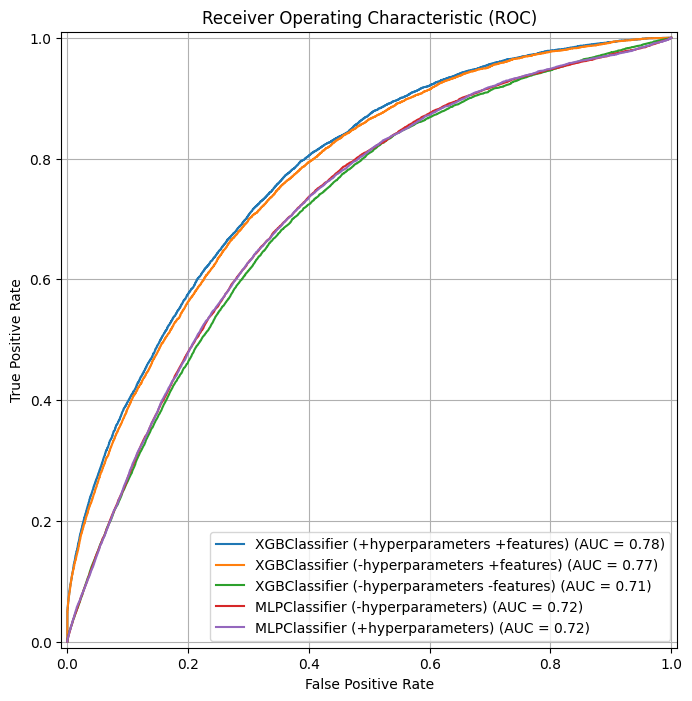

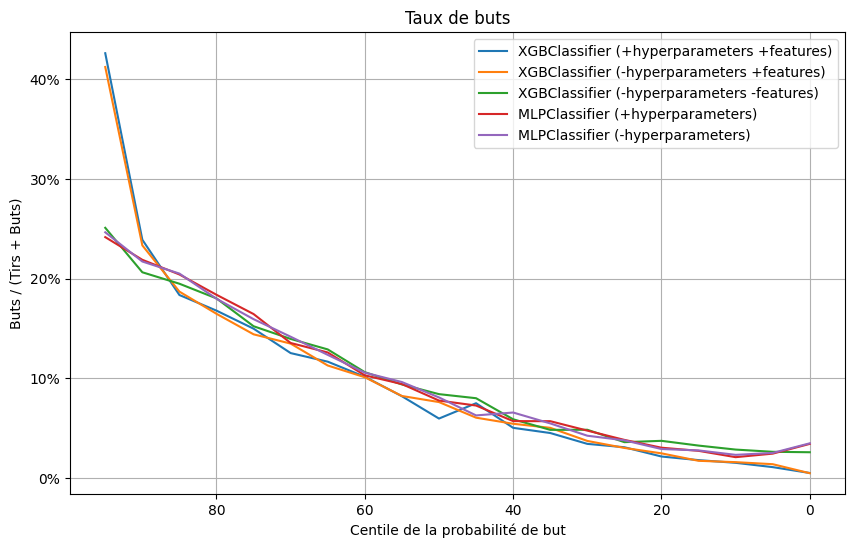

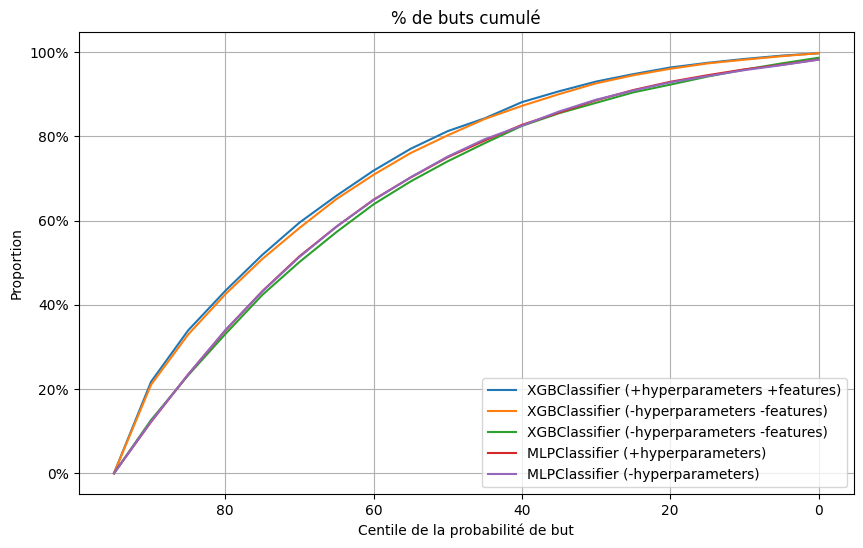

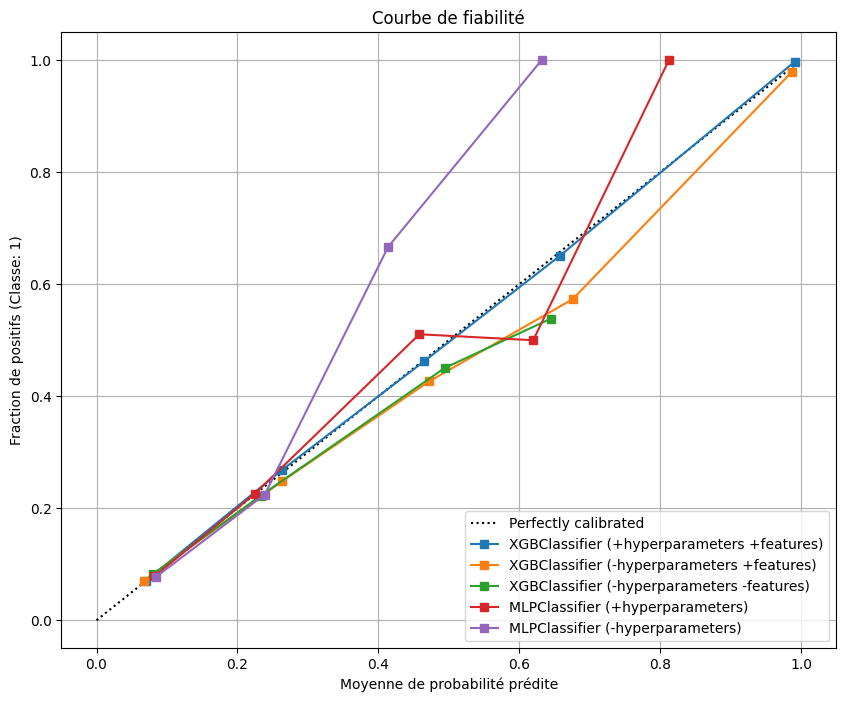

In [10]:
roc_models = []
roc_models.append(get_goal_probas(best_xgb, X_test_sel, y_test_sel, 'XGBClassifier (+hyperparameters +features)'))
roc_models.append(get_goal_probas(clf_xgb, X_test_sel, y_test_sel, 'XGBClassifier (-hyperparameters +features)'))
roc_models.append(get_goal_probas(base_xgb, X_test_base, y_test_base, 'XGBClassifier (-hyperparameters -features)'))
roc_models.append(get_goal_probas(base_mlp, X_test_mlp, y_test_mlp, 'MLPClassifier (-hyperparameters)'))
roc_models.append(get_goal_probas(best_mlp, X_test_mlp, y_test_mlp, 'MLPClassifier (+hyperparameters)'))

goal_rate_models = []
goal_rate_models.append(get_percentile_goal_rate(encoded_dataset, best_xgb, X_test_sel, y_test_sel, selected_features, 'XGBClassifier (+hyperparameters +features)'))
goal_rate_models.append(get_percentile_goal_rate(encoded_dataset, clf_xgb, X_test_sel, y_test_sel, selected_features, 'XGBClassifier (-hyperparameters +features)'))
goal_rate_models.append(get_percentile_goal_rate(encoded_dataset, base_xgb, X_test_base, y_test_base, ['distance', 'angle_to_goal'], 'XGBClassifier (-hyperparameters -features)'))
goal_rate_models.append(get_percentile_goal_rate(encoded_dataset, best_mlp, X_test_mlp, y_test_mlp, best_mlp.feature_names_in_, 'MLPClassifier (+hyperparameters)'))
goal_rate_models.append(get_percentile_goal_rate(encoded_dataset, base_mlp, X_test_mlp, y_test_mlp, base_mlp.feature_names_in_, 'MLPClassifier (-hyperparameters)'))

cum_goal_models = []
cum_goal_models.append(get_percentile_goal_cumul(encoded_dataset, best_xgb, X_test_sel, y_test_sel, selected_features, 'XGBClassifier (+hyperparameters +features)'))
cum_goal_models.append(get_percentile_goal_cumul(encoded_dataset, clf_xgb, X_test_sel, y_test_sel, selected_features, 'XGBClassifier (-hyperparameters -features)'))
cum_goal_models.append(get_percentile_goal_cumul(encoded_dataset, base_xgb, X_test_base, y_test_base, ['distance', 'angle_to_goal'], 'XGBClassifier (-hyperparameters -features)'))
cum_goal_models.append(get_percentile_goal_cumul(encoded_dataset, best_mlp, X_test_mlp, y_test_mlp, best_mlp.feature_names_in_, 'MLPClassifier (+hyperparameters)'))
cum_goal_models.append(get_percentile_goal_cumul(encoded_dataset, base_mlp, X_test_mlp, y_test_mlp, base_mlp.feature_names_in_, 'MLPClassifier (-hyperparameters)'))

calibration_models = []
calibration_models.append(get_goal_probas(best_xgb, X_test_sel, y_test_sel, 'XGBClassifier (+hyperparameters +features)'))
calibration_models.append(get_goal_probas(clf_xgb, X_test_sel, y_test_sel, 'XGBClassifier (-hyperparameters +features)'))
calibration_models.append(get_goal_probas(base_xgb, X_test_base, y_test_base, 'XGBClassifier (-hyperparameters -features)'))
calibration_models.append(get_goal_probas(best_mlp, X_test_mlp, y_test_mlp, 'MLPClassifier (+hyperparameters)'))
calibration_models.append(get_goal_probas(base_mlp, X_test_mlp, y_test_mlp, 'MLPClassifier (-hyperparameters)'))

# VISUALIZATION
roc_figure(roc_models)
goal_rate_figure(goal_rate_models)
goal_cumul_figure(cum_goal_models)
calibration_figure(calibration_models)